### Introduction to Ethereum's EIP-1559 and legacy transaction fee markets in general 

#### How does the Ethereum blockchain works with miners?

- In a blockchain, specifically Ethereum in our case, a **Proof of Work** (POW) blockchain, transactions are packed into **blocks** which are interconnected in a sequential manner through headers. 

- The person putting the transactions together is known as a **miner** and uses computational resources to bundle transactions, processing the transactions and keeping the chain growing (this can be expensive)

- Users submitting the transactions gives the miners a **tip** for including their transactions in the next block. The transaction fees that the user submitting the transaction pays is called the **gas price**.

- Miners are now economically incentivized to include and process transactions in the block, with hopes of their earnings from the tips being greater than their initial investment of running their mining nodes while helping to keep the Ethereum ecosystem by processing and validate transactions as well as maintaining security with decentralised consensus mechanism.

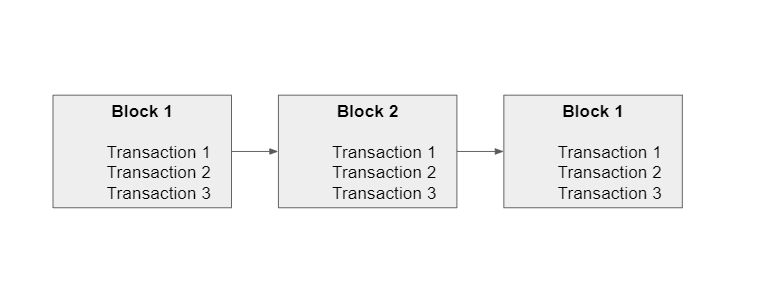

#### Old system:

- In the old system, the process of paying tips to get your transaction included in a block resembles a **first price auction** system.

- The higher gas price which the user was willing to pay for inclusion of transaction in a block, the more likely his/her's transaction is included in the next block to be processed.

#### Drawbacks: 

- High volatility in transaction fees occuring during high demand load on blockchain 
- Higher blocksize variance 
- Untruthful bidding 
- Over bidding for inclusion
- Unfairly pricing out users that cannot afford high gas prices during certain times
- Miners select those transactions of higher gas prices, neglecting those of lower gas price and resulting in longer transaction processing times for lower gas price transactions

#### New system:

- Under EIP-1559, it aimed to address these abovementioned issues by introducing a dynamically adjusted **base-fee** which is dependent on market conditions. This means transaction fees are now split into 2 components: basefee and **max priority fee** (miner's tip)

- When a user submits a transaction they will need to specify: what tip are they willing to pay, what is the maximum transaction fees they are willing to pay for inclusion (tip, maxfee)

- The basefee is calculated by the system based on a simple forumla as given below:

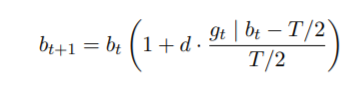

- In the above formula, `bt+1` is the base-fee at time (t+1) and `bt` the basefee at time (t), `gt|bt` is the number of transactions included in the block produced at time (t), `d` is a constant and `T/2` is the target block size (The block size that the system aims to achieve **on average**)

- The **max fee**, which is the max gas price user is willing to pay, is calculated as: `Max Fee = (2 * Base Fee) + Max Priority Fee`.

- The idea behind this upgrade is that the basefee increases when the space occupied by the transactions exceeds the target blocksize thereby making it more expensive for transactions to be included in the next block. Consequently when the space occupied by the transactions is lesser than the target blocksize, it becomes cheaper for transactions to get included in the next block.

- This tries to ensure that base fees are more predictable to users

- The equivalent to the gasprice in the old system is the `min(basefee + tip , maxfee)`

- The basefee is burnt (i.e removed out of circulation)

- The final fees that reaches the miner is: `min(maxfee - basefee , tip)`.


#### The objective of eip-1559 are as follows: 

- Reducing the volatility in gas-price while ensuring that on average the block size remains equal to the set target

- Prevention of overbidding for transaction inclusion

#### Drawbacks of eip-1559:

- One of the changes that this upgrade introduced to the protocol was that it increased the block size limit by a factor of 2X

- One of the biggest critiques against eip-1559 is that theoretically by doing so, there will be an increase in the variance in block size 
    - Although research has shows that short-term variance is not a big deal, but we shall not comment on this to prevent ensure that this project does not get overly technical

### Reference

Reijsbergen, D., Sridhar, S., Monnot, B., Leonardos, S., Skoulakis, S., & Piliouras, G. (2021). Transaction Fees on a Honeymoon: Ethereum's EIP-1559 One Month Later. _arXiv preprint arXiv:2110.04753._ [arXiv link](https://arxiv.org/pdf/2110.04753.pdf)

Leonardos, S., Monnot, B., Reijsbergen, D., Skoulakis, S., & Piliouras, G. (2021). Dynamical Analysis of the EIP-1559 Ethereum Fee Market. _arXiv preprint arXiv:2102.10567._ [arXiv link](https://arxiv.org/pdf/2102.10567.pdf)

### Objectives of our simulation model:

We want to evaluvate whether EIP1559 is succesful in its promises and if the drawbacks of the protocol actually hold. Furthermore, we would like to study how the basefee, maxfee and tip evolve over time in a more realistic scenario as well. 

We build a baseline model to:

1) Compare the metric of **gas prices** of the old system and new when the demand remains the same for a single run
2) Compare the metric of **block size** of the old system and new when the demand remains the same for a single run
2) Visualize how the **basefee**, **maxfee** and **tip** evolves in a single run
3) See if the average **block size**  w/ EIP1559 is the same as or close to the intended target (steady state analysis) in the long run

Consequently we will use realtime data extracted from the blockchain and build a model to see:

1) Visualize how the **basefee**, **max**, **fee**, **tip** and **gas price** evolve in a single run, under a scenario of realistic demand 
2) See if the average **block size** w/ EIP1559 is the same as or close to the intended target in the long run, under a situation of realistic demand (steady state analysis)

[BONUS: Dpending on the time left] We use a different basefee update rule and build a new model and:

1) See how it compares to the previous model in terms of if the average **block size** is the same as or close to the intended target under a situation of realistic demand (steady state analysis)
2) Insertion of man made events to show sudden spike in demand to simulate instances such as NFT minting events and check how each model performs under it

### How our simulation works in general with state diagram
![image.png](SMA_STATE_DIAGRAM.jpg)

#### In every time step:

1) New transactions submitted towards the blockchain, which are class objects (EIP1559 model: `eip1559_transaction`, Legacy model: `legacy_transactions` ), are created via demand functions (EIP1559 model: `demand_functions_eip1559`, Legacy model: `demand_functions_legacy`).
2) These transactions are "sent" to the MEMPOOL, which holds these pending transactions in place `demand_dict` dictionary object within the demand functions
3) "Miners" selects pending transactions within the MEMPOOL to be included in the block, also a class object,`block`, through the transaction selection functions (EIP1559 model: `transaction_selection_eip1559`, Legacy model: `transaction_selection_legacy`)
4) Pending transactions within each block is "processed" by miner under the transaction selection functions and processed block is "broadcasted to network" via the updating of global variables within the `initial_state` variable to be used in the next timestep via the functions `update_basefee` and `record_latest_block` (EIP1559 model: both functions, Legacy model: only `record_latest_block`)
5) Repeat steps above for next time step.

P.S. Classes, objects, variables and functions mentioned here are discussed below under the code

### Housekeeping

We first import all the necessary modules required to make the simulation run

In [ ]:
!pip install -r requirements.txt

In [27]:
# from functions import *
import random
import secrets
import pandas as pd
import numpy as np
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

### Constants

We first define all the constants in our model and store them in a dictionary. These are parameters that are intrinsic to the system and cannot be changed. 

#### For the new system they are:

- The `TARGET_SIZE` which is the target size that the system aims to achieve on average 

- The `MAX_BLOCK_SIZE` that is the maximum size that each block can be according to the new system

- The `BASEFEE_MAX_CHANGE_DENOMINATOR` which captures the constant `d` in the base fee update rule we previously mentioned above under basefee calculation

For the old system they are:

- The `MAX_BLOCK_SIZE` that is the maximum size that each block can be according to the old system

We have also defined some constants which we can change in our simulation model. They are:

- The `mempool_length` which is the size limit of the queue that holds all transactions 
- The `INITIAL_BASEFEE` which is the initial value to which the baseefee is instantiated 

In [28]:
## Constants

constants_eip1559 = {
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8,
    "TARGET_SIZE": 12500000,
    "MAX_BLOCK_SIZE": 25000000
}

constants_legacy = {
    "MAX_BLOCK_SIZE": 12500000,
}

levers = {
    "mempool_length": 1500,
    "INITIAL_BASEFEE": 1 * (10 ** 9),
}

### Classes

We move on to define 3 classes:

`eip1559_transaction`:

- In the new system each transaction has 4 components: The `total_gas_used` which is the total space the transaction occupies, the `fee_cap`: the maxfe, the `premium`: the tip and the `transaction_hash` which is the identity for the transaction (it also involves some complex cryptography magic)

`legacy_transaction`:

- In the old system we just have the: `total_gas_used`, the `transaction_hash` and the `fee` which is the gas price

`block`:

- Simply the block containing the transactions `transactions` which is of a fixed size `size`
- We also store the average gas price of all the transactions in the block in `avg_gas_price`

In [45]:
## Classes

class eip1559_transaction:
    def __init__(self,total_gas,fee_cap,premium):
        
        # Inherent txn propoerties 
        self.total_gas_used = total_gas
        self.transaction_hash = secrets.token_bytes(8)
        
        # User adjusted txn properties
        self.fee_cap = fee_cap
        self.premium = premium
        
class legacy_transaction:
    def __init__(self,total_gas,fee):
        
        # Inherent txn properties
        self.total_gas_used = total_gas
        self.transaction_hash = secrets.token_bytes(8)
        
        # User adjusted txn properties 
        self.fee = fee
        
class block:
    def __init__(self,size,transactions, avg_gas_price):
        self.size = size
        self.transactions = transactions 
        self.avg_gas_price = avg_gas_price

### Functions

`demand_functions_eip1559` and `demand_functions_legacy`

We have defined the functions for demand for each of the systems. For now we assume that:

- The transactions which are submitted are of a random size between: 2000 and 3000 
- The fees ascociated with them are also random in the range (1 X 10^9,11 X 10^9)
    - Here the fees are the `premium` and `fee_cap` in the case of EIP1559 and `gasprice` in the case of legacy transactions. Please note that all of them are measured per unit gas - i.e per unit space occupied in the block
    
`transaction_selection_eip1559` and `transaction_selection_legacy`

We have defined the functions for how the miners select which transactions get included in the next block. We simulate the most common strategy: Fill the block to the brim and make as much profit as possible

The steps are something like this:

- Process each transaction and sort them by the profits they bring to the table (`gasprices` in the legacy case and `min(premium - basefee, fee_cap)` in the eip1559 case)
- Given the space taken up by each of these transactions, select as many as possible keeping in mind the `MAX_BLOCK_SIZE`
- Pack everything up in a block and propogate that to the rest of the network 

`update_basefee`

This is a function that updates the basefee for the next timestep given the basefee from the previous timestep, the constant parameter `BASEFEE_MAX_CHANGE_DENOMINATOR` and the `TARGET_SIZE`
            
`record_latest_block`

This is a function that all agents in the network uses to record the latest block that has been produced


In [68]:
## Functions 

def demand_functions_eip1559(params, substep, state_history, previous_state, policy_input):
    
    number_of_transactions_in_mempool = levers['mempool_length']
    demand_dict = {}
    
    a = random.randint(1,11)
    b = random.randint(1,11)
    
    for i in range(number_of_transactions_in_mempool):
        tx = eip1559_transaction(
            total_gas = random.randint(20000,30000),
            premium = a*(10**9),
            fee_cap = b *(10**9)
        )
        demand_dict[tx.transaction_hash] = tx
        
        print("New transaction {}, submitted into the mempool".format(tx.transaction_hash))
    
    return ("demand", demand_dict)

def demand_functions_legacy(params, substep, state_history, previous_state, policy_input):
    
    number_of_transactions_in_mempool = levers['mempool_length']
    demand_dict = {}
    
    #a = random.randint(1,3)
    b = random.randint(1,11)
    
    for i in range(number_of_transactions_in_mempool):
        tx = legacy_transaction(
            total_gas = random.randint(20000,30000),
            #premium = a*(10**9),
            fee = b * (10 ** 9)
        )
        demand_dict[tx.transaction_hash] = tx
        
        print("New transaction {}, submitted into the mempool".format(tx.transaction_hash))
    
    return ("demand", demand_dict)


def transaction_selection_eip1559(params, substep, state_history, previous_state):
    
    demand_dict = previous_state["demand"] #simulates the MEMPOOL which is also the demand_dict returned at demand_function_eip
    basefee = previous_state["basefee"]
    
    size = constants_eip1559["MAX_BLOCK_SIZE"]
    final_fee_transactions = {}
    final_gas_prices = {}
    
    for i in demand_dict.keys():
        if basefee > demand_dict[i].fee_cap:
            continue
        else:
            final_fee_transactions[i] = min(demand_dict[i].fee_cap - basefee, demand_dict[i].premium)
            final_gas_prices[i] = min(basefee + demand_dict[i].premium, demand_dict[i].fee_cap)
            
    final_fee_transactions = dict(sorted(final_fee_transactions.items(), key=lambda x: x[1], reverse=True))
    
    included_transactions = []
    total_size_used = 0
    gas_fee_total = []
    
    for i in final_fee_transactions.keys():
        
        if total_size_used < size:
            included_transactions += [demand_dict[i]]
            total_size_used += demand_dict[i].total_gas_used
            gas_fee_total.append(final_gas_prices[i])
        
    print("{} Number of transactions being included in the next block".format(len(included_transactions)))
    
    if(len(gas_fee_total) == 0):
        avg_gas_price = 0
    else:
        avg_gas_price = sum(gas_fee_total)/len(gas_fee_total)
        
    return { "block": block(size = total_size_used, transactions = included_transactions, avg_gas_price = avg_gas_price)}
        
def transaction_selection_legacy(params, substep, state_history, previous_state):
    
    demand_dict = previous_state["demand"] #simulates the MEMPOOL which is also the demand_dict returned at demand_function_legacy
    
    size = constants_legacy["MAX_BLOCK_SIZE"]
    final_fee_transactions = {}
    
    for i in demand_dict.keys():
            final_fee_transactions[i] =  demand_dict[i].fee     
            
    final_fee_transactions = dict(sorted(final_fee_transactions.items(), key=lambda x: x[1], reverse=True))
    
    included_transactions = []
    total_size_used = 0
    gas_fee_total = []                     
    
    for i in final_fee_transactions.keys():
        
        if total_size_used < size:
            included_transactions += [demand_dict[i]]
            total_size_used += demand_dict[i].total_gas_used
            gas_fee_total.append(final_fee_transactions[i])
          
    print("{} Number of transactions being included in the next block".format(len(included_transactions)))
        
    return { "block": block(size = total_size_used, transactions = included_transactions, avg_gas_price = sum(gas_fee_total)/len(gas_fee_total)) }
        
def update_basefee(params, substep, state_history, previous_state, policy_input):
    
    gas_used = sum([i.total_gas_used for i in policy_input["block"].transactions])
    basefee = previous_state["basefee"]
    
    basefee = basefee + basefee * (gas_used - constants_eip1559["TARGET_SIZE"]) // constants_eip1559["TARGET_SIZE"] // constants_eip1559["BASEFEE_MAX_CHANGE_DENOMINATOR"]
    
    print("The new basefee is: {}".format(basefee))
          
    return ("basefee", basefee)


def record_latest_block(params, substep, state_history, previous_state, policy_input):
    
    block = policy_input["block"]
          
    print("New block recorded")
    
    return ("latest_block", block)

## Basic Model

It usually takes 12 seconds for a single block to be produced on Ethereum. We want to simulate an instance of 1 hour, thus we simulate 300 timesteps 

We now run the simulation for 300 blocks. The way radCAD (the simulation library we use) works is something like this:

- There are certain global variables which can be accessed by all agents. In our case we have 2 such global variables: `demand`and  `latest_block`
- We also have 2 policy variables - `block` and `basefee` 
- The steps of the simulation are executed in the order defined by `psub`
- In each step of the simulation we have 2 factors to take into consider, the `policy` and the `variable`
- The `policy` defines the particular action that is taken by the agent
- The `policy` always outputs a policy variable, which is fed as an input to the ascociated `action`
- The `variable` function performs some sort of computation based on the input policy variable and it outputs a gloabl variable that is recorded by every agent 
- We also initialse the global variables in `initial_state`
- We can define the number of timesteps for our simulation. Here we keep it as 300 which is equivalent to the number of block creations we want to simulate
- Once we set up the simulation and run the experiment, we can collect the experiment results output into a pandas dataframe 

We run one round of a 1000 timestep simulation and visualize the results we get. This is to ensure that the model is working well and to visualize and see some plots of the metrics that we wish to collect through the simulation. 

Subsiquently, we perform some steady state analysis to get the average basefee for a system with EIP-1559 in place

### Legacy

In [48]:
psub = [{
    "policies": {},
    "variables": {
        "demand": demand_functions_legacy # step 1
    }
}, {
    "policies": {
        "action": transaction_selection_legacy # step 2
    },
    "variables": {
        "latest_block": record_latest_block # step 3
    }
}]

initial_state = {
    "demand": {},
    "latest_block": block(size = 0, transactions=[], avg_gas_price = 0)
}

blocks = 300

model = Model(
    initial_state=initial_state,
    state_update_blocks=psub,
)
simulation = Simulation(model=model, timesteps=blocks, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=False, drop_substeps=True)
result = experiment.run()
df1 = pd.DataFrame(result) #experimental result

### EIP1559

In [69]:
psub = [{
    "policies": {},
    "variables": {
        "demand": demand_functions_eip1559 # step 1
    }
}, {
    "policies": {
        "action": transaction_selection_eip1559 # step 2
    },
    "variables": {
        "basefee": update_basefee, # step 3
        "latest_block": record_latest_block # step 3 too
    }
}]

initial_state = {
    "demand": {},
    "latest_block": block(size = 0, transactions=[], avg_gas_price = 0),
    "basefee": 10 * (10 ** 9)
}

blocks = 300

model = Model(
    initial_state=initial_state,
    state_update_blocks=psub,
)
simulation = Simulation(model=model, timesteps=blocks, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=False, drop_substeps=True)
result = experiment.run()
df2 = pd.DataFrame(result) #experimental result

#### Pre-Processing of dataframe results

In [95]:
df1["txs_per_block"] = df1.latest_block.apply(
    lambda block: len(block.transactions)
)
df1['block_size'] = df1.latest_block.apply(
    lambda block: block.size
)
df1['avg_gas_price'] = df1.latest_block.apply(
    lambda block: block.avg_gas_price
)



df2["txs_per_block"] = df2.latest_block.apply(
    lambda block: len(block.transactions)
)
df2['block_size'] = df2.latest_block.apply(
    lambda block: block.size
)
df2['avg_gas_price'] = df2.latest_block.apply(
    lambda block: block.avg_gas_price
)

N = 5
# Drop first N columns of dataframe
df_legacy = df1.iloc[: , N:]
df_eip1559 = df2.iloc[: , N:]
df_eip1559['basefee'] = df2['basefee']

In [96]:
df_legacy

,substep,timestep,txs_per_block,block_size,avg_gas_price
0,0,0,0,0,0.000000e+00
1,2,1,501,12513338,1.000000e+09
2,2,2,500,12521966,1.100000e+10
3,2,3,500,12504774,1.000000e+09
4,2,4,496,12503749,8.000000e+09
...,...,...,...,...,...
296,2,296,502,12501118,1.000000e+10
297,2,297,499,12519320,2.000000e+09
298,2,298,501,12501448,2.000000e+09
299,2,299,500,12519154,5.000000e+09


In [97]:
df_eip1559

,run,substep,timestep,txs_per_block,block_size,avg_gas_price,basefee
0,1,0,0,0,0,0.000000e+00,10000000000
1,1,2,1,0,0,0.000000e+00,8750000000
2,1,2,2,0,0,0.000000e+00,7656250000
3,1,2,3,1004,25023712,9.656250e+09,8615096700
4,1,2,4,0,0,0.000000e+00,7538209612
...,...,...,...,...,...,...,...
296,1,2,296,999,25001996,9.085015e+09,3470703117
297,1,2,297,997,25012220,1.000000e+10,3904965126
298,1,2,298,0,0,0.000000e+00,3416844485
299,1,2,299,996,25004304,1.000000e+10,3844097106


## OBJECTIVE 1: Gas price - new v/s old

### Legacy

<AxesSubplot:xlabel='timestep'>

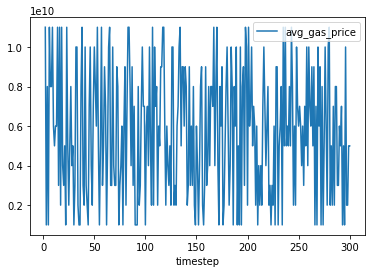

In [79]:
df1[df1.timestep > 1].plot("timestep", "avg_gas_price")

In [80]:
df1['avg_gas_price'].var()

1.0526976744186046e+19

<AxesSubplot:ylabel='Frequency'>

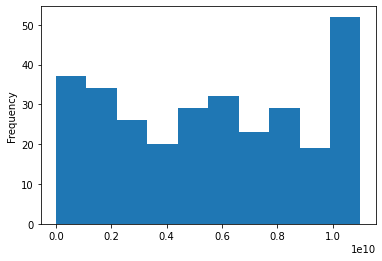

In [84]:
df1['avg_gas_price'].plot(kind = 'hist')

### eip1559

<AxesSubplot:xlabel='timestep'>

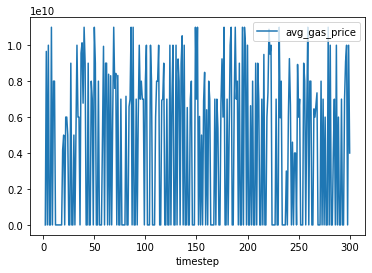

In [81]:
df2[df2.timestep > 1].plot("timestep", "avg_gas_price")

In [83]:
df2['avg_gas_price'].var()

1.7678682350698623e+19

<AxesSubplot:ylabel='Frequency'>

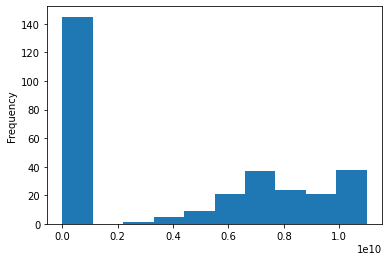

In [85]:
df2['avg_gas_price'].plot(kind = 'hist')

## Objective 2: Block size - new v/s old

### Legacy

<AxesSubplot:xlabel='timestep'>

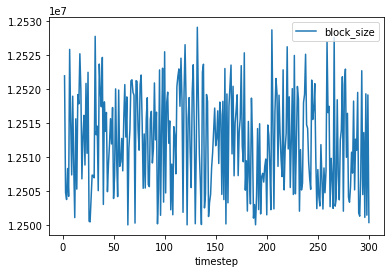

In [87]:
df1[df1.timestep > 1].plot("timestep", "block_size")

In [88]:
df1['block_size'].var()

520179833597.91705

### eip1559

<AxesSubplot:xlabel='timestep'>

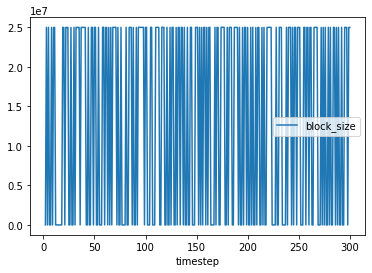

In [89]:
df2[df2.timestep > 1].plot("timestep", "block_size")

In [91]:
df2['block_size'].var()

156707904878105.7

In [93]:
print("The variance after eip1559 is {} times higher than in the legacy case".format(df2['block_size'].var()/df1['block_size'].var()))

The variance after eip1559 is 301.2571706100319 times higher than in the legacy case


## OBJECTIVE 3: Base fee, Maxfee and Tip evolution  

### Base fee

<AxesSubplot:xlabel='timestep'>

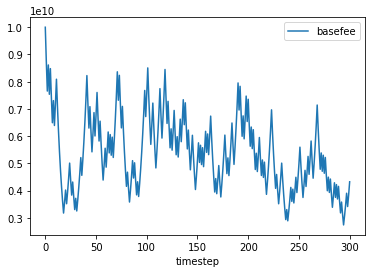

In [99]:
df2.plot('timestep', ['basefee'])

### Max fee and tip

In [126]:
df2["avg_tip"] = df2.latest_block.apply(
    lambda block: pd.Series([tx.premium for tx in block.transactions]).mean()
)

df2["avg_max_fee"] = df2.latest_block.apply(
    lambda block: pd.Series([tx.fee_cap for tx in block.transactions]).mean()
)

df2["avg_max_fee"] = df2["avg_max_fee"].fillna(0)
df2["avg_tip"] = df2["avg_tip"].fillna(0)

<ipython-input-126-93ec5dfce26e>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda block: pd.Series([tx.premium for tx in block.transactions]).mean()
<ipython-input-126-93ec5dfce26e>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda block: pd.Series([tx.fee_cap for tx in block.transactions]).mean()


<AxesSubplot:>

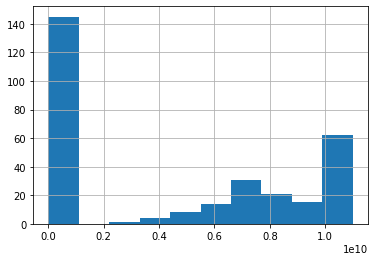

In [127]:
df2["avg_max_fee"].hist(bins = 10)

<AxesSubplot:>

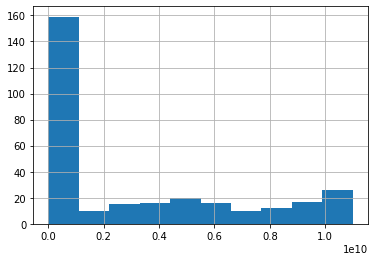

In [128]:
df2["avg_tip"].hist(bins = 10)

## OBJECTIVE 4: Finding the Average Basefee using steady state analysis 

In [133]:
nrep_initial = 100
mean_i = 0
var_i = 0
i = 1
keep_going = True

def simulate_once_eip1559():
    psub = [{
        "policies": {},
        "variables": {
            "demand": demand_functions_eip1559 # step 1
        }
    }, {
        "policies": {
            "action": transaction_selection_eip1559 # step 2
        },
        "variables": {
            "basefee": update_basefee, # step 3
            "latest_block": record_latest_block 
        }
    }]

    initial_state = {
        "demand": {},
        "latest_block": block(size = 0, transactions=[], avg_gas_price = 0),
        "basefee": 10 * (10 ** 9)
    }

    blocks = 30

    model = Model(
        initial_state=initial_state,
        state_update_blocks=psub,
    )
    simulation = Simulation(model=model, timesteps=blocks, runs=1)
    experiment = Experiment([simulation])
    experiment.engine = Engine(deepcopy=False, drop_substeps=True)
    result = experiment.run()
    df = pd.DataFrame(result)
    
    return(df['basefee'])
    

while keep_going == True:
    
    S = simulate_once_eip1559().mean()
    
    mean_prev = mean_i
    var_prev = var_i
    
    mean_i = mean_prev + (S - mean_prev)/(i)
    
    if(i > 1):
        var_i = (1-1/(i-1))*var_prev + i*(mean_i - mean_prev)**2
        
    se = (var_i/i)**(0.5)
    
    if(i > nrep_initial):
        keep_going = False
    
    else:
        i += 1
        
print("The expected basefee is: {}".format(mean_i))
print("The standard error of the estimate is: {}".format(se))
print("The difference form the target is: {}".format(abs(constants_eip1559["TARGET_SIZE"] - mean_i)))

The expected basefee is: 6427867038.806133
The standard error of the estimate is: 62859726.89961139
The difference form the target is: 6415367038.806133
